In [1]:
import pandas as pd
import rasterio
from rasterstats import zonal_stats
from osgeo import gdal
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyproj import CRS
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pyproj

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#read tif file
day_285 = pd.read_csv("D:/nightlight study/fl_2018_285.csv")

In [3]:
day_285.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN


In [4]:
day_285.shape

(2869587, 8)

In [5]:
day_285['_mean'].count()

508823

In [6]:
wind = pd.read_csv("D:/nightlight study/Florida_Akshay.csv")
wind.head()

,ID,Center_Latitude,Center_Longitude,Vmax
0,0,32.224223,-87.451826,18.872683
1,1,32.219746,-87.452504,18.866529
2,2,32.215270,-87.453181,18.909298
3,3,32.210793,-87.453858,18.903135
4,4,32.206316,-87.454535,18.896965


In [5]:
wind = wind[["ID","Vmax"]]
wind.head()

,ID,Vmax
0,0,18.872683
1,1,18.866529
2,2,18.909298
3,3,18.903135
4,4,18.896965


In [7]:
landcover_zonal = pd.read_csv("D:/nightlight study/landcover_zonal_Florida.csv")
histo_columns = ['HISTO_0', 'HISTO_1', 'HISTO_3', 'HISTO_4', 'HISTO_6', 'HISTO_7',
                 'HISTO_8', 'HISTO_9', 'HISTO_10', 'HISTO_14', 'HISTO_15', 
                 'HISTO_16', 'HISTO_17', 'HISTO_18', 'HISTO_NODATA']

# Convert HISTO columns to percentages
landcover_zonal[histo_columns] = landcover_zonal[histo_columns].div(landcover_zonal[histo_columns].sum(axis=1), axis=0) * 100
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
landcover_zonal.shape

(2869587, 20)

In [9]:
landcover_zonal.describe()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
count,2.869587e+06,2.869587e+06,2.869587e+06,2.869587e+06,2.869587e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06
mean,1.434794e+06,1.609478e+06,-1.750593e+06,1.609978e+06,-1.751093e+06,2.594725e-02,3.121913e-05,4.621494e+00,3.734352e-02,1.762164e-01,1.026153e+00,1.137760e-05,7.365143e-01,7.183839e-06,9.470279e+00,4.567325e+00,1.028247e-01,4.090330e+00,9.395936e-01,7.420593e+01
std,8.283786e+05,2.455182e+05,2.434975e+05,2.455182e+05,2.434975e+05,7.302946e-01,2.574040e-02,1.522863e+01,7.445504e-01,1.739659e+00,5.802961e+00,1.372608e-02,5.042180e+00,6.492462e-03,2.457536e+01,1.740347e+01,1.725802e+00,1.604158e+01,7.985033e+00,4.357711e+01
min,1.000000e+00,1.184478e+06,-2.172093e+06,1.184978e+06,-2.172593e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.173975e+05,1.396978e+06,-1.961593e+06,1.397478e+06,-1.962093e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.434794e+06,1.609478e+06,-1.750593e+06,1.609978e+06,-1.751093e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
75%,2.152190e+06,1.821978e+06,-1.539593e+06,1.822478e+06,-1.540093e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
max,2.869587e+06,2.034478e+06,-1.329093e+06,2.034978e+06,-1.329593e+06,1.000000e+02,3.010381e+01,1.000000e+02,8.345588e+01,9.653979e+01,1.000000e+02,2.041522e+01,1.000000e+02,7.266436e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02


In [10]:
landcover_zonal[landcover_zonal["HISTO_17"]>0].shape

(305277, 20)

In [15]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [16]:
import netCDF4 as nc
import pandas as pd

In [11]:
rainfall = pd.read_csv("D:/nightlight study/October_12.csv")
rainfall.head()

,Unnamed: 0,Center_Latitude,Center_Longitude,Rainfall
0,0,32.219746,-87.452504,0.0
1,1,32.215270,-87.453181,0.0
2,2,32.210793,-87.453858,0.0
3,3,32.206316,-87.454535,0.0
4,4,32.201839,-87.455211,0.0


In [12]:
rainfall = rainfall.rename(columns={'Unnamed: 0': 'id'})

In [13]:
night_month = pd.read_csv("D:/nightlight study/fl_a3_m10.csv")
night_month.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN


In [14]:
night_month.shape

(2869587, 8)

In [15]:
night_month['_mean'].count()

596469

In [16]:
night_month = night_month.rename(columns={'_mean': 'nightlight_prev'})
night_month = night_month[["id","nightlight_prev"]]
night_month.head()

,id,nightlight_prev
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [17]:
night_month = night_month.dropna()
night_month.head()

,id,nightlight_prev
5361,5362,0.0
5362,5363,0.0
5363,5364,0.0
7046,7047,0.0
7047,7048,0.0


In [18]:
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
wind.head()

,ID,Center_Latitude,Center_Longitude,Vmax
0,0,32.224223,-87.451826,18.872683
1,1,32.219746,-87.452504,18.866529
2,2,32.215270,-87.453181,18.909298
3,3,32.210793,-87.453858,18.903135
4,4,32.206316,-87.454535,18.896965


In [20]:
day_285.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN


In [21]:
day_285=day_285.dropna()

In [22]:
day_285.shape

(508823, 8)

In [25]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(day_285,how="inner",on="id")
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left_x,top_x,right_x,bottom_x,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Center_Latitude_x,Center_Longitude_x,Vmax,left_y,top_y,right_y,bottom_y,_count,_sum,_mean,nightlight_prev,Center_Latitude_y,Center_Longitude_y,Rainfall
0,5362,1.185978e+06,-1.479093e+06,1.186478e+06,-1.479593e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.250000,0.0,0.0,0.0,0.0,98.750000,5362.0,30.873352,-87.634830,21.133494,1.185978e+06,-1.479093e+06,1.186478e+06,-1.479593e+06,0.256606,0.179569,0.699785,0.0,30.868865,-87.635473,0.0
1,5363,1.185978e+06,-1.479593e+06,1.186478e+06,-1.480093e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,62.352941,0.0,0.0,0.0,0.0,37.647059,5363.0,30.868865,-87.635473,21.130450,1.185978e+06,-1.479593e+06,1.186478e+06,-1.480093e+06,0.116311,0.069838,0.600439,0.0,30.864379,-87.636115,0.0
2,5364,1.185978e+06,-1.480093e+06,1.186478e+06,-1.480593e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,23.529412,0.0,0.0,0.0,0.0,76.470588,5364.0,30.864379,-87.636115,21.127441,1.185978e+06,-1.480093e+06,1.186478e+06,-1.480593e+06,0.002987,0.001792,0.600000,0.0,30.859893,-87.636758,0.0
3,7047,1.186478e+06,-1.478093e+06,1.186978e+06,-1.478593e+06,0.0,0.0,2.768166,0.0,0.0,0.0,0.0,0.0,0.0,35.986159,0.0,0.0,0.0,0.0,61.245675,7047.0,30.881676,-87.628381,21.140300,1.186478e+06,-1.478093e+06,1.186978e+06,-1.478593e+06,0.781308,0.780924,0.999509,0.0,30.877190,-87.629024,0.0
4,7048,1.186478e+06,-1.478593e+06,1.186978e+06,-1.479093e+06,0.0,0.0,7.266436,0.0,0.0,0.0,0.0,0.0,0.0,65.743945,0.0,0.0,0.0,0.0,26.989619,7048.0,30.877190,-87.629024,21.196257,1.186478e+06,-1.478593e+06,1.186978e+06,-1.479093e+06,0.718019,0.374572,0.521674,0.0,30.872704,-87.629667,0.0


In [26]:
regression_df = regression_df.drop(['id', 'left_x', 'top_x', 'right_x', 'bottom_x','ID','Center_Latitude_x',
                                    'Center_Longitude_x','HISTO_NODATA'], axis=1)
regression_df.shape

(508822, 26)

In [27]:
regression_df.columns

Index(['HISTO_0', 'HISTO_1', 'HISTO_3', 'HISTO_4', 'HISTO_6', 'HISTO_7',
       'HISTO_8', 'HISTO_9', 'HISTO_10', 'HISTO_14', 'HISTO_15', 'HISTO_16',
       'HISTO_17', 'HISTO_18', 'Vmax', 'left_y', 'top_y', 'right_y',
       'bottom_y', '_count', '_sum', '_mean', 'nightlight_prev',
       'Center_Latitude_y', 'Center_Longitude_y', 'Rainfall'],
      dtype='object')

In [28]:
#remove rows with no urban
#only keep rows with values for target column

regression_df = regression_df[regression_df["HISTO_17"]>0]
regression_df.shape

(274478, 26)

In [29]:
regression_df.describe()

,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,left_y,top_y,right_y,bottom_y,_count,_sum,_mean,nightlight_prev,Center_Latitude_y,Center_Longitude_y,Rainfall
count,274478.000000,274478.000000,274478.000000,274478.000000,274478.00000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,2.744780e+05,2.744780e+05,2.744780e+05,2.744780e+05,2.744780e+05,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000
mean,0.056838,0.000256,22.457377,0.132622,0.63252,4.579320,0.000084,3.427571,0.000059,22.897001,15.197121,0.414905,27.360284,1.660334,12.452505,1.663925e+06,-1.579141e+06,1.664425e+06,-1.579641e+06,1.505273e+00,6.590759,4.484062,4.493048,29.223425,-82.916968,0.269237
std,1.017808,0.073920,26.153786,1.223338,2.93527,11.023324,0.039113,9.998500,0.018646,27.451222,26.452839,3.122677,31.246685,7.436644,25.689366,1.857183e+05,1.220031e+05,1.857183e+05,1.220031e+05,4.226715e-01,16.743774,10.799955,10.739211,1.308150,1.765325,1.012859
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346021,0.000000,0.000000,1.188478e+06,-2.067093e+06,1.188978e+06,-2.067593e+06,2.494067e-08,0.000000,0.000000,0.000000,24.539524,-87.604504,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.920415,0.000000,0.000000,1.547978e+06,-1.659593e+06,1.548478e+06,-1.660093e+06,1.327992e+00,0.576665,0.400000,0.000000,28.282622,-83.905262,0.000000
50%,0.000000,0.000000,11.029412,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,11.072664,0.000000,0.000000,11.397059,0.000000,0.000000,1.719478e+06,-1.537593e+06,1.719978e+06,-1.538093e+06,1.349359e+00,1.020802,0.700000,0.539974,29.622600,-82.373326,0.000000
75%,0.000000,0.000000,39.705882,0.000000,0.00000,3.460208,0.000000,1.730104,0.000000,37.716263,19.031142,0.000000,40.073529,0.000000,0.000000,1.796478e+06,-1.482593e+06,1.796978e+06,-1.483093e+06,2.000000e+00,4.200000,3.080811,3.450000,30.324640,-81.656891,0.049277
max,93.771626,30.103806,99.653979,74.632353,86.15917,99.632353,20.415225,99.653979,7.266436,99.653979,99.653979,96.539792,100.000000,99.653979,97.650806,1.993478e+06,-1.388093e+06,1.993978e+06,-1.388593e+06,3.000000e+00,590.600000,403.827382,267.400000,30.998070,-80.048295,10.617115


In [58]:
regression_df.to_csv("D:/nightlight study/michael_regressor.csv")

### Machine Learning Models

#### Linear Regression

In [30]:
regression_df.describe()

,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,left_y,top_y,right_y,bottom_y,_count,_sum,_mean,nightlight_prev,Center_Latitude_y,Center_Longitude_y,Rainfall
count,274478.000000,274478.000000,274478.000000,274478.000000,274478.00000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,2.744780e+05,2.744780e+05,2.744780e+05,2.744780e+05,2.744780e+05,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000,274478.000000
mean,0.056838,0.000256,22.457377,0.132622,0.63252,4.579320,0.000084,3.427571,0.000059,22.897001,15.197121,0.414905,27.360284,1.660334,12.452505,1.663925e+06,-1.579141e+06,1.664425e+06,-1.579641e+06,1.505273e+00,6.590759,4.484062,4.493048,29.223425,-82.916968,0.269237
std,1.017808,0.073920,26.153786,1.223338,2.93527,11.023324,0.039113,9.998500,0.018646,27.451222,26.452839,3.122677,31.246685,7.436644,25.689366,1.857183e+05,1.220031e+05,1.857183e+05,1.220031e+05,4.226715e-01,16.743774,10.799955,10.739211,1.308150,1.765325,1.012859
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346021,0.000000,0.000000,1.188478e+06,-2.067093e+06,1.188978e+06,-2.067593e+06,2.494067e-08,0.000000,0.000000,0.000000,24.539524,-87.604504,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.920415,0.000000,0.000000,1.547978e+06,-1.659593e+06,1.548478e+06,-1.660093e+06,1.327992e+00,0.576665,0.400000,0.000000,28.282622,-83.905262,0.000000
50%,0.000000,0.000000,11.029412,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,11.072664,0.000000,0.000000,11.397059,0.000000,0.000000,1.719478e+06,-1.537593e+06,1.719978e+06,-1.538093e+06,1.349359e+00,1.020802,0.700000,0.539974,29.622600,-82.373326,0.000000
75%,0.000000,0.000000,39.705882,0.000000,0.00000,3.460208,0.000000,1.730104,0.000000,37.716263,19.031142,0.000000,40.073529,0.000000,0.000000,1.796478e+06,-1.482593e+06,1.796978e+06,-1.483093e+06,2.000000e+00,4.200000,3.080811,3.450000,30.324640,-81.656891,0.049277
max,93.771626,30.103806,99.653979,74.632353,86.15917,99.632353,20.415225,99.653979,7.266436,99.653979,99.653979,96.539792,100.000000,99.653979,97.650806,1.993478e+06,-1.388093e+06,1.993978e+06,-1.388593e+06,3.000000e+00,590.600000,403.827382,267.400000,30.998070,-80.048295,10.617115


In [31]:
nan_count = regression_df.isna().sum()
print(nan_count)

HISTO_0               0
HISTO_1               0
HISTO_3               0
HISTO_4               0
HISTO_6               0
HISTO_7               0
HISTO_8               0
HISTO_9               0
HISTO_10              0
HISTO_14              0
HISTO_15              0
HISTO_16              0
HISTO_17              0
HISTO_18              0
Vmax                  0
left_y                0
top_y                 0
right_y               0
bottom_y              0
_count                0
_sum                  0
_mean                 0
nightlight_prev       0
Center_Latitude_y     0
Center_Longitude_y    0
Rainfall              0
dtype: int64


In [32]:
df = regression_df.copy()

#df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('_mean', axis=1)  # Independent variables
y = df['_mean']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : -0.022926749641722012
HISTO_1 : -0.03007805196604396
HISTO_3 : -0.55845057753003
HISTO_4 : -0.024418940988064797
HISTO_6 : -0.07533230484082401
HISTO_7 : -0.23181152827341922
HISTO_8 : -0.02752621387576807
HISTO_9 : -0.20270772490429978
HISTO_10 : 0.04577378786848676
HISTO_14 : -0.6085793353036373
HISTO_15 : -0.5948829692557172
HISTO_16 : -0.09464327465979644
HISTO_17 : -0.8247948614155602
HISTO_18 : -0.17360086387048507
Vmax : -0.1433555883588598
left_y : -6.731625151688466
top_y : 3.7773472458434454
right_y : -6.731625151688481
bottom_y : 3.7773472458433983
_count : -0.77092645783376
_sum : 6.815010737120885
nightlight_prev : 4.0552031469397125
Center_Latitude_y : -10.583582392537183
Center_Longitude_y : 10.055800282275221
Rainfall : 0.006116159476298995
R2 score on the test set: 0.9457719254899895


#### Poisson Regression

In [33]:
import statsmodels.api as sm
import pandas as pd

# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = '_mean'
independent_vars = [col for col in df.columns if col != target]

# Fit the Poisson GLM
X = df[independent_vars]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df[target]

poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print the summary of the model
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  _mean   No. Observations:               274478
Model:                            GLM   Df Residuals:                   274454
Model Family:                 Poisson   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.4897e+05
Date:                Tue, 20 Jun 2023   Deviance:                   6.8188e+05
Time:                        14:32:05   Pearson chi2:                 9.57e+05
No. Iterations:                   100   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0092   6.61

In [34]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

df = regression_df.copy()
# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = '_mean'
independent_vars = [col for col in df.columns if col != target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[independent_vars], df[target], test_size=0.2, random_state=42)

# Scale the independent variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Poisson GLM on the training data
X_train_scaled = sm.add_constant(X_train_scaled)  # Add a constant term for the intercept
poisson_model = sm.GLM(y_train, X_train_scaled, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Predict on the test data
X_test_scaled = sm.add_constant(X_test_scaled)  # Add a constant term for the intercept
y_pred = poisson_results.predict(X_test_scaled)

# Evaluate the performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  164.13586198664242


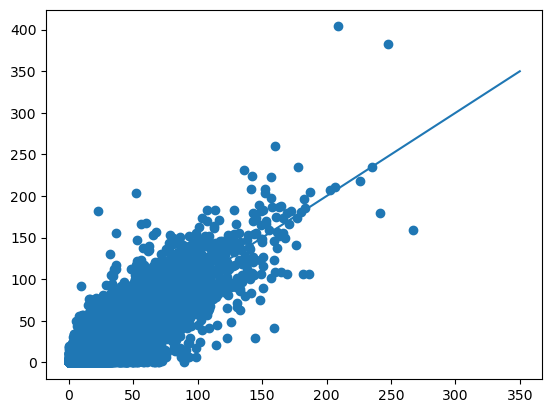

In [35]:
plt.scatter(x=df["nightlight_prev"],y=df["_mean"])
plt.plot([0,350],[0,350])
plt.show()

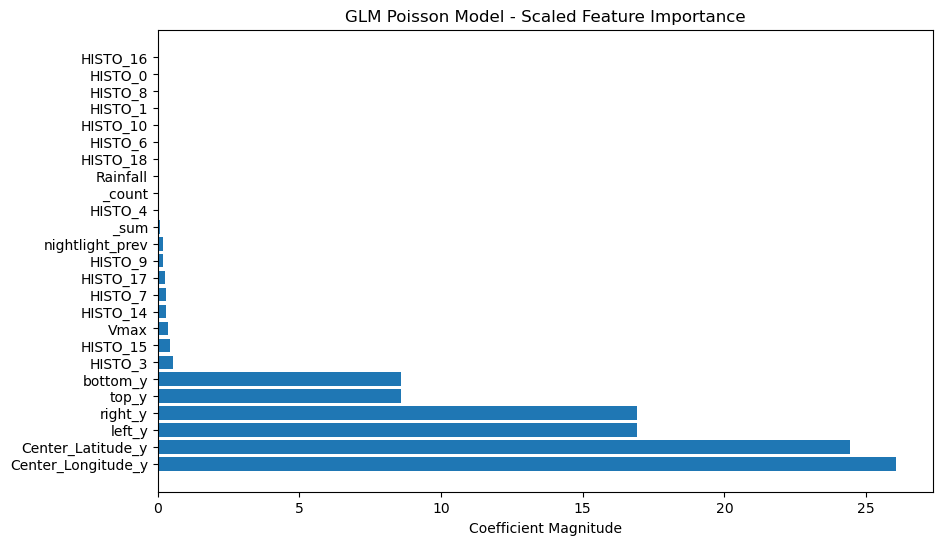

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in a pandas DataFrame called 'data'
# X should contain the features used in your model
X = df[independent_vars]
y = df[target]

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a GLM Poisson model on the scaled data
glm_model = sm.GLM(y, sm.add_constant(X_scaled), family=sm.families.Poisson()).fit()

# Get the absolute values of the coefficients
coef_abs = np.abs(glm_model.params[1:])

# Sort the coefficients in descending order
sorted_indices = np.argsort(coef_abs)[::-1]
sorted_coef_abs = coef_abs[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = X.columns[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_coef_abs)), sorted_coef_abs, align='center')
plt.yticks(range(len(sorted_coef_abs)), sorted_feature_names)
plt.xlabel('Coefficient Magnitude')
plt.title('GLM Poisson Model - Scaled Feature Importance')
plt.show()

### Recovery

In [37]:
day_279 = pd.read_csv("D:/nightlight study/fl_2018_279.csv")
day_279 = day_279[["id","_mean"]]

In [38]:
day_285 = day_285[["id","_mean"]]

In [39]:
day_279.head()

,id,_mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [40]:
df2 = day_279.merge(day_285,on="id",how="inner")
df2.head()

,id,_mean_x,_mean_y
0,5362,1.098492,0.699785
1,5363,0.400431,0.600439
2,5364,0.300000,0.600000
3,7047,0.599902,0.999509
4,7048,0.504463,0.521674


In [41]:
df2.shape

(508823, 3)

In [42]:
df2["outage"] = (df2["_mean_x"] - df2["_mean_y"])/df2["_mean_x"]*100
df2.head()
df2 = df2[["id","outage"]]
df2.head()

,id,outage
0,5362,36.295903
1,5363,-49.948039
2,5364,-100.000000
3,7047,-66.612087
4,7048,-3.411703


In [43]:
df2.shape

(508823, 2)

In [44]:
df2 = df2[df2["outage"]>0]
df2.shape

(167075, 2)

In [45]:
day_288 = pd.read_csv("D:/nightlight study/fl_2018_288.csv")

In [46]:
day_288 = day_288[["id","_mean"]]
day_288.head()

,id,_mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [47]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(df2,how="inner",on="id")
regression_df = regression_df.merge(day_288,how="inner",on="id")
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Center_Latitude_x,Center_Longitude_x,Vmax,outage,_mean,nightlight_prev,Center_Latitude_y,Center_Longitude_y,Rainfall
0,5362,1.185978e+06,-1.479093e+06,1.186478e+06,-1.479593e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.250000,0.0,0.0,0.0,0.0,98.750000,5362.0,30.873352,-87.634830,21.133494,36.295903,1.098492,0.0,30.868865,-87.635473,0.0
1,7049,1.186478e+06,-1.479093e+06,1.186978e+06,-1.479593e+06,0.0,0.0,25.735294,0.0,0.0,0.0,0.0,0.0,0.0,66.544118,0.0,0.0,0.0,0.0,7.720588,7049.0,30.872704,-87.629667,21.193169,18.750000,0.800000,0.0,30.868218,-87.630310,0.0
2,8730,1.186978e+06,-1.476093e+06,1.187478e+06,-1.476593e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,45.588235,0.0,0.0,0.0,0.0,54.411765,8730.0,30.898973,-87.620642,21.212874,83.333333,0.600000,0.0,30.894487,-87.621286,0.0
3,8731,1.186978e+06,-1.476593e+06,1.187478e+06,-1.477093e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,71.626298,0.0,0.0,0.0,0.0,28.373702,8731.0,30.894487,-87.621286,21.209606,42.362684,0.600000,0.0,30.890001,-87.621930,0.0
4,8732,1.186978e+06,-1.477093e+06,1.187478e+06,-1.477593e+06,0.0,0.0,0.346021,0.0,0.0,0.0,0.0,0.0,0.0,35.294118,0.0,0.0,0.0,0.0,64.359862,8732.0,30.890001,-87.621930,21.206371,33.421627,0.600000,0.0,30.885515,-87.622573,0.0


In [48]:
regression_df = regression_df.dropna(subset=['nightlight_prev'])
regression_df.shape

(167075, 30)

In [49]:
regression_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'HISTO_0', 'HISTO_1', 'HISTO_3',
       'HISTO_4', 'HISTO_6', 'HISTO_7', 'HISTO_8', 'HISTO_9', 'HISTO_10',
       'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18',
       'HISTO_NODATA', 'ID', 'Center_Latitude_x', 'Center_Longitude_x', 'Vmax',
       'outage', '_mean', 'nightlight_prev', 'Center_Latitude_y',
       'Center_Longitude_y', 'Rainfall'],
      dtype='object')

In [51]:
regression_df = regression_df.drop(['id', 'left', 'top', 'right', 'bottom','ID',"Center_Latitude_x",
                                    "Center_Longitude_x"], axis=1)
regression_df.shape

(167075, 22)

In [52]:
regression_df = regression_df[regression_df["HISTO_17"]>0]
regression_df.shape

(102316, 22)

In [53]:
regression_df = regression_df.dropna(subset=['_mean'])
regression_df.shape

(102316, 22)

In [54]:
df = regression_df.copy()

df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('_mean', axis=1)  # Independent variables
y = df['_mean']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : 0.059052083091561944
HISTO_1 : 3484625023.1843276
HISTO_3 : 0.06152384723080227
HISTO_4 : 0.010534099376863537
HISTO_6 : -0.06993958157997628
HISTO_7 : 0.043680770328273895
HISTO_8 : -6966932862.888286
HISTO_9 : 0.07333029001680488
HISTO_10 : 6954496827.273281
HISTO_14 : 0.1009513252901989
HISTO_15 : 0.07211320579308526
HISTO_16 : 0.022798345210826007
HISTO_17 : -0.5947897200928703
HISTO_18 : 0.016962606662682924
Vmax : -0.4972475425336436
outage : 1.018690854741381
nightlight_prev : 15.126180226269673
Center_Latitude_y : 0.0931812363970725
Center_Longitude_y : -0.09976078286830473
Rainfall : 0.021526814828412164
R2 score on the test set: -1.0616184169505756e+18


#### Random Forrest

In [55]:
# Split the data into features (X) and target variable (y)
X = df.drop('_mean', axis=1)
y = df['_mean']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest regressor object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

In [56]:
# Train the Random Forest model
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [57]:
# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 19.632539277173986
